In [1]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np

import scanpy as sc
from anndata import AnnData
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, rc_context

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})

In [8]:
def calculate_detected_intensities(df, threshold=0.8):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    Also add detectability column, where compounds with prediction value above threshold=0.8 are labelled as detected (1)
    '''

    df['detectability'] = df.pred_val >= threshold
    vals = df.spot_intensity_bgr_corrected * df.detectability
    df['effective_intensity'] = np.clip(vals, 0, None)
    return df


def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata


def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df


def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df


def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df


def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    return data


def group_by_molecule(df, groupby_columns):
    '''
    Aggregate intensity and detection values per groupby columns
    '''          
    data = df.groupby(groupby_columns).agg({
        'effective_intensity' : 'sum',
        'detectability' : 'max'}).reset_index()
    return data


def summarise_per_class(df, groupby_columns):
    
    data = df.groupby(groupby_columns).agg({'detectability' : 'sum',
                                            'class_size': 'first',
                                            'effective_intensity' : 'mean'
                                            }).reset_index()

    data['fraction_detected'] = data.detectability / data['class_size'] 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    return data


def assemble_adata(pca):
    observables = pca.index.to_frame(index=False)
    for col in observables.columns:
        observables[col] = observables[col].astype('category')  
    variables = pca.columns.to_frame(index=False)
    adata = AnnData(pca.values, obs=observables, var=variables)
    return adata

- Inputs

In [9]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"
p_out = p_root_dir / "6_plots/q2_plots/pca_plots/EMBL_3ppm"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_1Jul2022.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"

- Merge relevant info into one dataframe

In [10]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)[['dataset_id', 
                                                       'name_short', 
                                                       'adduct', 
                                                       'neutral_loss', 
                                                       'pred_val',
                                                       'spot_intensity_bgr_corrected']]
predictions.neutral_loss.fillna('', inplace=True)

# Add dataset metadata 
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code', 'EMBL']]
datasets_info['sample_name'] = datasets_info['Matrix short']

# Merge with predictions
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

# Filter to keep only datasets chosen for plots about matrix comparison
df = df[df.EMBL]

# only consider data of detected ions
df = calculate_detected_intensities(df, threshold=0.8)
data = df[df.detectability]

In [11]:
# Load classification, add class size info

classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = get_class_size(classes[['name_short', 'main_coarse_class']].drop_duplicates(), 
                            'main_coarse_class')
chem_subclass = get_class_size(classes[['name_short', 'coarse_class', 'fine_class']],  # coarse class here is to sort rows in the plot
                              'fine_class')

## Option 1: Build PCA based on the intenisities and detectability of all metabolites
- Each metabolite is an average of its detected ions

In [6]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
#                             polarity='negative', 
                            neutral_losses=['']
                           )

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule(filtered_data, groupby_columns=['Matrix short', 'Polarity', 'name_short'])

pca = molecule_data.pivot_table(values=['effective_intensity', 'detectability'], 
                                         index=['Matrix short', 'Polarity'], 
                                         columns='name_short',
                                         fill_value=0)

# Assemble adata
adata = assemble_adata(pca)

# Apply log10(x+1) transform and Z-score normalisation
sc.pp.log1p(adata, base=10)
sc.pp.scale(adata, zero_center=True)

# Compute PCA
sc.tl.pca(adata, svd_solver='arpack')

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


... storing 0 as categorical
... storing 'name_short' as categorical
<ipython-input-7-116a83fbb1b0>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


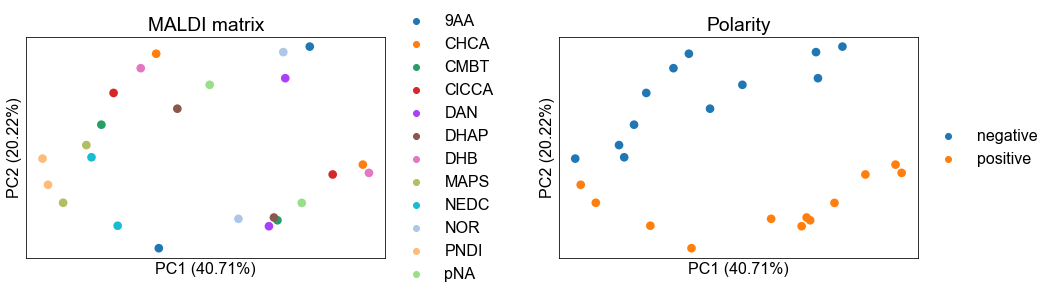

In [7]:
# fname = "PCA_EMBL_matrices_neg"
# with rc_context():    
#     ax = sc.pl.pca(adata, 
#                    components=['1, 2'], 
#                    color=['Matrix short'],
#                    size=300, 
#                    ncols=2,
#                    legend_loc='right margin',
#                    show=False, 
#                    wspace=0.35,
#                    annotate_var_explained = True)
#     ax.set_title('MALDI matrix')
#     plt.tight_layout()
#     plt.savefig(p_out/ f"{fname}.png")
#     plt.savefig(p_out / f"{fname}.pdf")


fname = "PCA_EMBL_matrices_both"
with rc_context():    
    ax = sc.pl.pca(adata, 
                   components=['1, 2'], 
                   color=['Matrix short', 'Polarity'],
                   size=300, 
                   ncols=2,
                   legend_loc='right margin',
                   show=False, 
                   wspace=0.35,
                   annotate_var_explained = True)
    ax[0].set_title('MALDI matrix')
    ax[1].set_title('Polarity')
    plt.tight_layout()
#     plt.savefig(p_out/ f"{fname}.png")
#     plt.savefig(p_out / f"{fname}.pdf")

## Option 2: PCA based on the aggregated values also used in coarse class dot plot
- This is useful in case you want to see PCA loadings

In [12]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
                            polarity='positive', 
                            neutral_losses=['']
                           )

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule(filtered_data, groupby_columns=['Matrix short', 'Polarity', 'name_short'])

# Map chemical classes
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

# Summarise data per class
class_data = summarise_per_class(mapped_data, groupby_columns=['Matrix short', 'Polarity', 'main_coarse_class'])

# Reshape
pca = class_data.pivot_table(values=['effective_intensity', 'fraction_detected'], 
                       index=['Matrix short', 'Polarity'], 
                       columns='main_coarse_class', 
                       fill_value=0)

# Assemble adata
adata = assemble_adata(pca)

# Apply log10(x+1) transform and Z-score normalisation
sc.pp.log1p(adata, base=10)
sc.pp.scale(adata, zero_center=True)

# Compute PCA
sc.tl.pca(adata, svd_solver='arpack')

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
fname = "PCA_EMBL_matrices_coarse_class_pos"
with rc_context():    
    ax = sc.pl.pca(adata, 
                   components=['1, 2'], 
                   color=['Matrix short'],
                   size=300, 
                   ncols=2,
                   legend_loc='right margin',
                   show=False, 
                   wspace=0.35,
                   annotate_var_explained = True)
    ax.set_title('MALDI matrix')
    plt.tight_layout()
    plt.savefig(p_out/ f"{fname}.png")
    plt.savefig(p_out / f"{fname}.pdf")


# fname = "PCA_EMBL_matrices_coarse_class_both"
# with rc_context():    
#     ax = sc.pl.pca(adata, 
#                    components=['1, 2'], 
#                    color=['Matrix short', 'Polarity'],
#                    size=300, 
#                    ncols=2,
#                    legend_loc='right margin',
#                    show=False, 
#                    wspace=0.35,
#                    annotate_var_explained = True)
#     ax[0].set_title('MALDI matrix')
#     ax[1].set_title('Polarity')
#     plt.tight_layout()
#     plt.savefig(p_out/ f"{fname}.png")
#     plt.savefig(p_out / f"{fname}.pdf")

In [ ]:
# # Extras

# # See how much PCA components explain variance
# sc.pl.pca_variance_ratio(adata)

# # Check loading plot
# sc.pl.pca_loadings(adata, components='1,2')

## Option 3: PCA based on the aggregated values also used in fine class dot plot
- All three opotions provide similar result, but this can be useful for the loading plot

In [ ]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
#                             polarity='negative', 
                            neutral_losses=['']
                           )

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule(filtered_data, groupby_columns=['Matrix short', 'Polarity', 'name_short'])

# Map chemical classes
mapped_data = molecule_data.merge(chem_subclass, on='name_short', how='left')

# Summarise data per class
class_data = summarise_per_class(mapped_data, groupby_columns=['Matrix short', 'Polarity', 'fine_class'])

# Reshape
pca = class_data.pivot_table(values=['effective_intensity', 'fraction_detected'], 
                       index=['Matrix short', 'Polarity'], 
                       columns='fine_class', 
                       fill_value=0)

# Assemble adata
adata = assemble_adata(pca)

# Apply log10(x+1) transform and Z-score normalisation
sc.pp.log1p(adata, base=10)
sc.pp.scale(adata, zero_center=True)

# Compute PCA
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
# fname = "PCA_EMBL_matrices_fine_class_pos"
# with rc_context():    
#     ax = sc.pl.pca(adata, 
#                    components=['1, 2'], 
#                    color=['Matrix short'],
#                    size=300, 
#                    ncols=2,
#                    legend_loc='right margin',
#                    show=False, 
#                    wspace=0.35,
#                    annotate_var_explained = True)
#     ax.set_title('MALDI matrix')
#     plt.tight_layout()
#     plt.savefig(p_out/ f"{fname}.png")
#     plt.savefig(p_out / f"{fname}.pdf")


fname = "PCA_EMBL_matrices_fine_class_both"
with rc_context():    
    ax = sc.pl.pca(adata, 
                   components=['1, 2'], 
                   color=['Matrix short', 'Polarity'],
                   size=300, 
                   ncols=2,
                   legend_loc='right margin',
                   show=False, 
                   wspace=0.35,
                   annotate_var_explained = True)
    ax[0].set_title('MALDI matrix')
    ax[1].set_title('Polarity')
    plt.tight_layout()
    plt.savefig(p_out/ f"{fname}.png")
    plt.savefig(p_out / f"{fname}.pdf")